In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from numpy import linalg as LA

In [2]:
df_visit=pd.read_csv("visitor_log.csv")
df_theft=pd.read_csv("theft_log.csv", names=['tday'], header=None)
df_theft["theft"]=1

# Data Cleaning

##### Checked is there any same name in our dataset. To determine that I used dob columns and names.As you may see 7 name belongs to mutual person. To solve this problem I merged "name" and "dob" columns. Right now this new columns will have unique names like ID.

In [3]:
df_group=df_visit.groupby(["name","dob"]).count().reset_index()
df_group=df_group[["name","dob"]]
df_group2=df_group[["name","dob"]].groupby(["name"])["dob"].count().reset_index()
np.sum(df_group[["name","dob"]].groupby(["name"])["dob"].count().reset_index()["dob"]>1)

7

In [4]:
df_visit["name"]=df_visit.name+" "+df_visit.dob 

##### In this part dealed with data types. Data is very clean so I just aranged dates from str to datetime.

In [5]:
df_theft.tday=pd.to_datetime(df_theft.tday,format="%Y-%m-%d")
df_theft=df_theft.set_index("tday")

In [6]:
df_visit.visit_date=pd.to_datetime(df_visit.visit_date,format="%Y-%m-%d")
df_visit=df_visit.set_index("visit_date")

# Visualization

##### In this part I checked theft days with number of daily visitors. 
Observation: Stolen phone situation can be encountered in every part of year. So we must focus on whole date. Also looks like we have some consecutive thief day. Looks like we have more than 1 thief.

In [7]:
df_visit_temp=df_visit.dob.resample("D").count().reset_index()
df_visit_temp=df_visit_temp.set_index("visit_date")

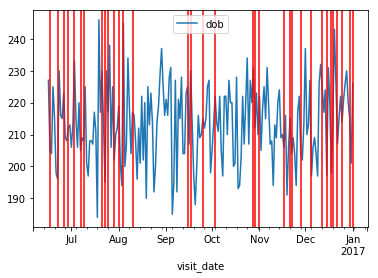

In [8]:
df_visit_temp.plot()
for i in range(len(df_theft)):
    plt.axvline(x=df_theft.index[i],color="red")

# Feature Design

In [9]:
customers=pd.DataFrame(df_visit.name.value_counts()).reset_index() # Firtly created customers dataset. So I can work on 
customers.rename(index=str, columns={"index": "name", "name": "number_visit"},inplace=True)

In [10]:
df_visit=pd.read_csv("visitor_log.csv")
df_theft=pd.read_csv("theft_log.csv", names=['tday'], header=None)
df_theft["theft"]=1
df_visit["name"]=df_visit.name+" "+df_visit.dob

df_all=pd.merge(df_visit, df_theft, how='outer',left_on='visit_date', right_on='tday')
df_all.drop(["tday"], axis=1,inplace=True)
df_all.fillna(0,inplace=True)

theft_number=df_all.groupby(["name"]).sum()
theft_number.reset_index(inplace=True)
customers=pd.merge(customers, theft_number, how='outer',left_on='name', right_on='name')

##### Theft day customer in club/ total visit of customer

In [11]:
customers["theft/visit"]=customers.theft/customers.number_visit

##### Theft day customer in club/ Total theft day

In [12]:
customers["theftin/ttotal"]=customers.theft/len(df_theft)

##### Is there any theft in first day of customer

In [13]:
df_theft.tday=pd.to_datetime(df_theft.tday,format="%Y-%m-%d")
df_visit.visit_date=pd.to_datetime(df_visit.visit_date,format="%Y-%m-%d")

time_list=[]
for i in range(len(df_theft)):  # theft day convert to list
    time_list.append(df_theft.tday[i])

first_day=pd.DataFrame(df_visit.groupby("name")["visit_date"].min().reset_index())

first_day["first_day"]=0
for i in range(len(first_day)):
    first_day["first_day"][i]=first_day.visit_date[i] in time_list
    
customers=pd.merge(customers, first_day[["name","first_day"]], how='outer',left_on='name', right_on='name')

customers["first_day"].replace(True,1,inplace=True)
customers["first_day"].replace(False,0,inplace=True)



C:\Users\yigit\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\yigit\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


##### Is there any theft in last day of customer

In [14]:


last_day=pd.DataFrame(df_visit.groupby("name")["visit_date"].max().reset_index())

last_day["last_day"]=0
for i in range(len(last_day)):
    last_day["last_day"][i]=last_day.visit_date[i] in time_list
    
customers=pd.merge(customers, last_day[["name","last_day"]], how='outer',left_on='name', right_on='name')

customers["last_day"].replace(True,1,inplace=True)
customers["last_day"].replace(False,0,inplace=True)

C:\Users\yigit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\yigit\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Visilization of features

Observations: As we can see our features have some ourliers and looks like that outliers may be our most suspicious customer to be thief. 

Text(0.5,1,'Theft day')

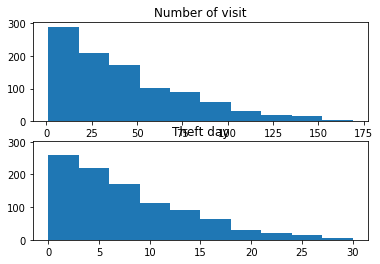

In [15]:
f, axarr = plt.subplots(2, sharey=True)
axarr[0].hist(customers.number_visit)
axarr[0].set_title('Number of visit')

axarr[1].hist(customers.theft)
axarr[1].set_title('Theft day')

Text(0.5,1,'theftin/ttotal')

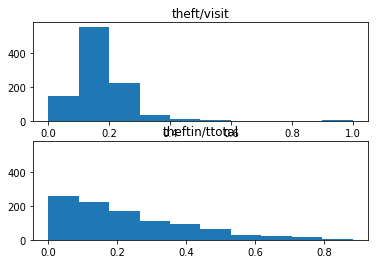

In [16]:
f, axarr = plt.subplots(2, sharey=True)
axarr[0].hist(customers["theft/visit"])
axarr[0].set_title('theft/visit')

axarr[1].hist(customers["theftin/ttotal"])
axarr[1].set_title('theftin/ttotal')

Text(0.5,1,'Theft day')

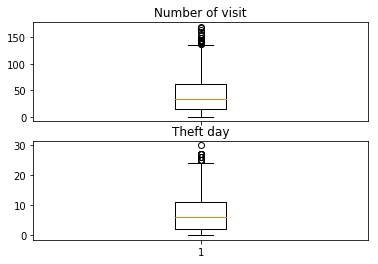

In [17]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].boxplot(customers.number_visit)
axarr[0].set_title('Number of visit')

axarr[1].boxplot(customers.theft)
axarr[1].set_title('Theft day')



Text(0.5,1,'theftin/ttotal')

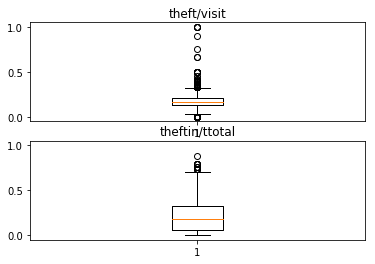

In [18]:
f, axarr = plt.subplots(2, sharey=True)
axarr[0].boxplot(customers["theft/visit"])
axarr[0].set_title('theft/visit')

axarr[1].boxplot(customers["theftin/ttotal"])
axarr[1].set_title('theftin/ttotal')

### Scaling

I will scale may features from 0 to 1 because in next step we will have model which can be directly efected by magnitute of features.

In [19]:
customers["number_visit"].max()

169

In [20]:
customers["number_visit"]=customers["number_visit"]/customers["number_visit"].max()
customers["theft"]=customers["theft"]/customers["theft"].max()
customers["theft/visit"]=customers["theft/visit"]/customers["theft/visit"].max()
customers["theftin/ttotal"]=customers["theftin/ttotal"]/customers["theftin/ttotal"].max()

# Model

##### Semi supervised learning by Euclidean Distance with Hierarchical Clustering approach

We have unsupervised dataset. However 81 customers have never been in club in theft day. So at least we have some innocent customer and that makes our dataset semisupervised. I want to cluster my dataset with bias to our innocent customers. So I calculated mean Euclidean Distance to innocent customer for every other customers. That approach is also used in Hierarchical Clustering method. This can be called as simple custom application of Hierarchical Clustering.

In [21]:
clean_c=customers[customers["theft"]==0].reset_index()
customers["distance"]=0
for i in range(len(customers)):
    distance=[]
    
    for j in range(len(clean_c)):
        distance.append(LA.norm(clean_c.loc[j,"number_visit":"last_day"]-customers.loc[i,"number_visit":"last_day"]))
        
    customers.loc[i,"distance"]=np.mean(distance)

In [23]:
customers.sort_values(by="distance",ascending=False)[["name"]].head(20)

,name
14,Karen Keeney 1993-12-25
4,Patricia Whitley 1993-06-08
3,Arthur Freund 1996-09-07
10,Lynn Bernhart 1995-11-13
30,Raymond Shannon 1997-08-06
18,Cynthia Allen 1996-08-29
44,Cynthia Dominquez 1996-05-16
1,Christine Victoria 1996-11-26
82,Linda Gomez 1996-03-08
2,Dale Kirkwood 1993-05-22
